In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os


In [2]:
from scipy.spatial.distance import pdist, squareform

#### Explore distribution of ClassyFire categories to consider how these compare with the NCC categories

In [3]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP +'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [4]:
classyfire = pd.read_csv(processed_dir+'ClassyFire.csv', index_col = 0)

In [6]:
classyfire.Kingdom.value_counts()

Organic compounds      13477
Inorganic compounds      593
Other                    179
Name: Kingdom, dtype: int64

<AxesSubplot:>

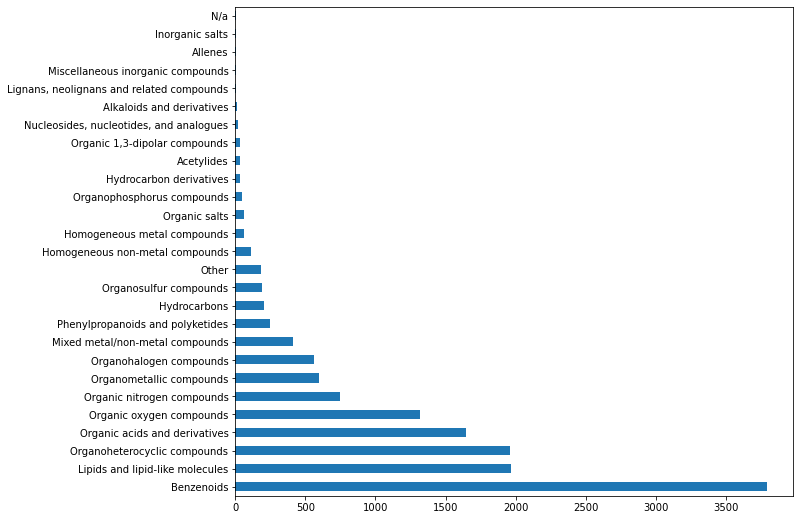

In [8]:
classyfire.Superclass.value_counts(dropna = False).plot.barh(figsize = (10,9))

In [9]:
(classyfire.Superclass.value_counts()>1000).index

Index(['Benzenoids', 'Lipids and lipid-like molecules',
       'Organoheterocyclic compounds', 'Organic acids and derivatives',
       'Organic oxygen compounds', 'Organic nitrogen compounds',
       'Organometallic compounds', 'Organohalogen compounds',
       'Mixed metal/non-metal compounds', 'Phenylpropanoids and polyketides',
       'Hydrocarbons', 'Organosulfur compounds', 'Other',
       'Homogeneous non-metal compounds', 'Homogeneous metal compounds',
       'Organic salts', 'Organophosphorus compounds',
       'Hydrocarbon derivatives', 'Acetylides',
       'Organic 1,3-dipolar compounds',
       'Nucleosides, nucleotides, and analogues', 'Alkaloids and derivatives',
       'Lignans, neolignans and related compounds',
       'Miscellaneous inorganic compounds', 'Allenes', 'Inorganic salts',
       'N/a'],
      dtype='object')

<AxesSubplot:>

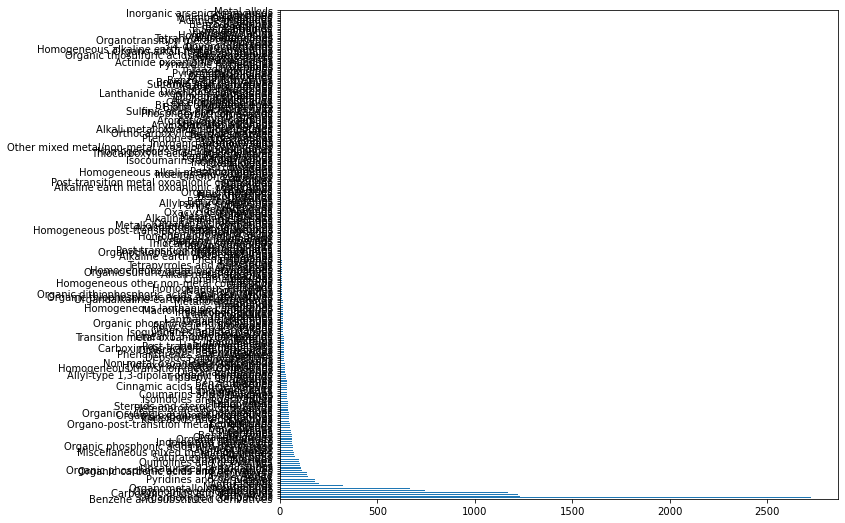

In [10]:
classyfire.Class.value_counts(dropna = False).plot.barh(figsize=(10,9))

In [20]:
classyfire.Class.nunique()

270

In [11]:
classyfire['Superclass'].value_counts()

Benzenoids                                   3795
Lipids and lipid-like molecules              1968
Organoheterocyclic compounds                 1964
Organic acids and derivatives                1646
Organic oxygen compounds                     1319
Organic nitrogen compounds                    746
Organometallic compounds                      595
Organohalogen compounds                       561
Mixed metal/non-metal compounds               414
Phenylpropanoids and polyketides              248
Hydrocarbons                                  206
Organosulfur compounds                        187
Other                                         179
Homogeneous non-metal compounds               111
Homogeneous metal compounds                    63
Organic salts                                  62
Organophosphorus compounds                     44
Hydrocarbon derivatives                        35
Acetylides                                     33
Organic 1,3-dipolar compounds                  30


In [12]:
classyfire.nunique()

dtxsid        14247
Kingdom           3
Superclass       27
Class           270
dtype: int64

In [19]:
count_freq = dict(classyfire['Superclass'].value_counts())
count_freq

superclass_gt1000 = list({k for k,v in count_freq.items() if v >1000})

In [20]:
superclass_gt1000

['Organic acids and derivatives',
 'Organic oxygen compounds',
 'Organoheterocyclic compounds',
 'Lipids and lipid-like molecules',
 'Benzenoids']

In [21]:
classyfire['ClassyFire'] = classyfire[['Superclass', 'Class']].apply(lambda x : x['Class'] if x['Superclass'] in superclass_gt1000 else x['Superclass'] , axis = 1)

In [22]:
classyfire.ClassyFire.nunique()

176

<AxesSubplot:>

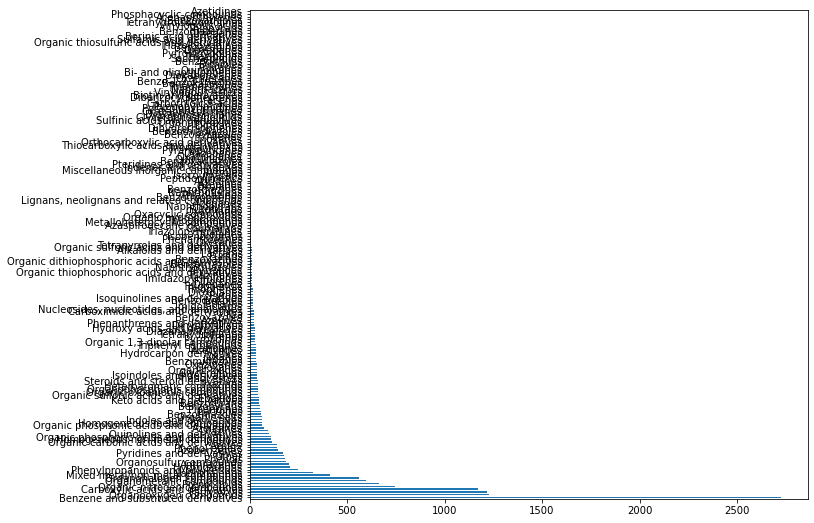

In [23]:
classyfire.ClassyFire.value_counts(dropna = False).plot.barh(figsize=(10,9))

In [24]:
classyfire.ClassyFire.unique()

Benzene and substituted derivatives    2725
Organooxygen compounds                 1230
Fatty Acyls                            1220
Carboxylic acids and derivatives       1169
Organic nitrogen compounds              746
                                       ... 
Tetrahydroisoquinolines                   1
Benzoxathioles                            1
Acenaphthylenes                           1
Phosphacyclic compounds                   1
Azetidines                                1
Name: ClassyFire, Length: 176, dtype: int64

In [29]:
superclass_class_dict = {k:set(v) for k,v in classyfire.groupby('Superclass')['Class']}

In [32]:
superclass_class_dict['Lipids and lipid-like molecules']

{'Fatty Acyls',
 'Glycerolipids',
 'Glycerophospholipids',
 'Prenol lipids',
 'Saccharolipids',
 'Steroids and steroid derivatives'}

In [39]:
classyfire

,dtxsid,Kingdom,Superclass,Class,ClassyFire
0,DTXSID3060164,Organic compounds,Benzenoids,Triphenyl compounds,Triphenyl compounds
1,DTXSID7060837,Organic compounds,Organohalogen compounds,Organoiodides,Organohalogen compounds
2,DTXSID9025879,Organic compounds,Phenylpropanoids and polyketides,Cinnamic acids and derivatives,Phenylpropanoids and polyketides
3,DTXSID2026282,Organic compounds,Benzenoids,Anthracenes,Anthracenes
4,DTXSID4052188,Organic compounds,Organic oxygen compounds,Organooxygen compounds,Organooxygen compounds
...,...,...,...,...,...
14244,DTXSID5064209,Organic compounds,Organoheterocyclic compounds,Benzothiazoles,Benzothiazoles
14245,DTXSID7062873,Organic compounds,Lipids and lipid-like molecules,Fatty Acyls,Fatty Acyls
14246,DTXSID9040342,Organic compounds,Organic acids and derivatives,Organic carbonic acids and derivatives,Organic carbonic acids and derivatives
14247,DTXSID3044889,Organic compounds,Organic oxygen compounds,Organooxygen compounds,Organooxygen compounds


In [50]:
grp_SC = classyfire.groupby(['Superclass', 'Class']).agg({'Class': 'count'}).rename(columns = {'Class': 'Count'}).reset_index()

In [52]:
grp_SC[grp_SC['Superclass'].isin(superclass_gt1000)]

,Superclass,Class,Count
7,Benzenoids,Acenaphthylenes,1
8,Benzenoids,Anthracenes,201
9,Benzenoids,Benzene and substituted derivatives,2725
10,Benzenoids,Dibenzocycloheptenes,1
11,Benzenoids,Fluorenes,14
...,...,...,...
226,Organoheterocyclic compounds,Triazinanes,14
227,Organoheterocyclic compounds,Triazines,43
228,Organoheterocyclic compounds,Triazolopyridines,1
229,Organoheterocyclic compounds,Triazolopyrimidines,8


In [76]:
grp_SC[grp_SC['Superclass']== superclass_gt1000[4]]

,Superclass,Class,Count
7,Benzenoids,Acenaphthylenes,1
8,Benzenoids,Anthracenes,201
9,Benzenoids,Benzene and substituted derivatives,2725
10,Benzenoids,Dibenzocycloheptenes,1
11,Benzenoids,Fluorenes,14
12,Benzenoids,Indanes,35
13,Benzenoids,Indenes and isoindenes,3
14,Benzenoids,N/a,13
15,Benzenoids,Naphthacenes,1
16,Benzenoids,Naphthalenes,324


In [55]:
pd.get_option("display.max_rows")
pd.set_option('display.max_rows', 200)

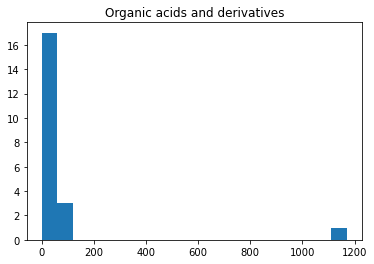

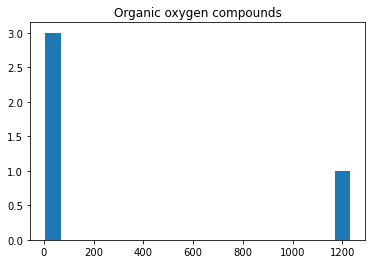

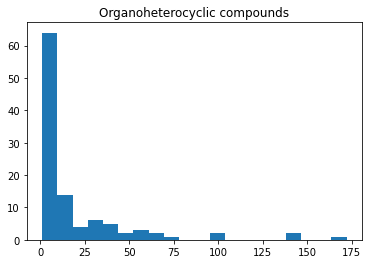

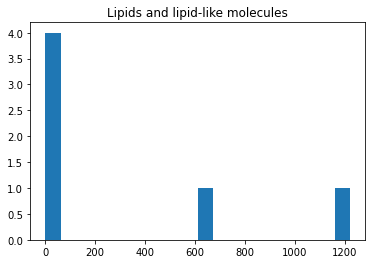

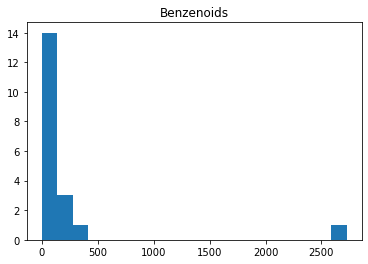

In [69]:
for i, group in enumerate(superclass_gt1000):
    fig  = plt.figure(i)
    plt.hist(grp_SC[grp_SC['Superclass'] == group]['Count'], bins = 20)
    plt.title(group)

In [77]:
grp_SC

,Superclass,Class,Count
0,Acetylides,N/a,33
1,Alkaloids and derivatives,Cinchona alkaloids,3
2,Alkaloids and derivatives,N/a,3
3,Alkaloids and derivatives,Strychnos alkaloids,2
4,Alkaloids and derivatives,Tropane alkaloids,2
...,...,...,...
274,Phenylpropanoids and polyketides,Macrolides and analogues,14
275,Phenylpropanoids and polyketides,Neoflavonoids,2
276,Phenylpropanoids and polyketides,Phenylpropanoic acids,6
277,Phenylpropanoids and polyketides,Stilbenes,52


In [79]:
df = grp_SC[grp_SC['Superclass'].isin(superclass_gt1000)]

In [96]:
df[df['Superclass'] == 'Benzenoids']

,Superclass,Class,Count
7,Benzenoids,Acenaphthylenes,1
8,Benzenoids,Anthracenes,201
9,Benzenoids,Benzene and substituted derivatives,2725
10,Benzenoids,Dibenzocycloheptenes,1
11,Benzenoids,Fluorenes,14
12,Benzenoids,Indanes,35
13,Benzenoids,Indenes and isoindenes,3
14,Benzenoids,N/a,13
15,Benzenoids,Naphthacenes,1
16,Benzenoids,Naphthalenes,324


In [94]:
mydict = {}
for i, group in df.groupby('Superclass'):
    subset = group[['Class', 'Count']]
    a = subset[subset['Count'] >= 30] 
    v = list(a['Class'])
    mydict[i] = v

In [113]:
mydict['Benzenoids']

['Anthracenes',
 'Benzene and substituted derivatives',
 'Indanes',
 'Naphthalenes',
 'Phenol esters',
 'Phenol ethers',
 'Phenols',
 'Triphenyl compounds']

In [116]:
mylst = []
for i, row in classyfire.iterrows():
    if (row['Superclass'] in list(mydict.keys())) and (row['Class'] in mydict[row['Superclass']]):
        mylst.append(row['Class'])
    else:
        mylst.append(row['Superclass'])

In [117]:
len(mylst)

14249

In [118]:
classyfire['ClassyFire'] = mylst

In [127]:
classyfire.ClassyFire.value_counts().head()

Benzene and substituted derivatives    2725
Organooxygen compounds                 1230
Fatty Acyls                            1220
Carboxylic acids and derivatives       1169
Organic nitrogen compounds              746
Name: ClassyFire, dtype: int64

<AxesSubplot:>

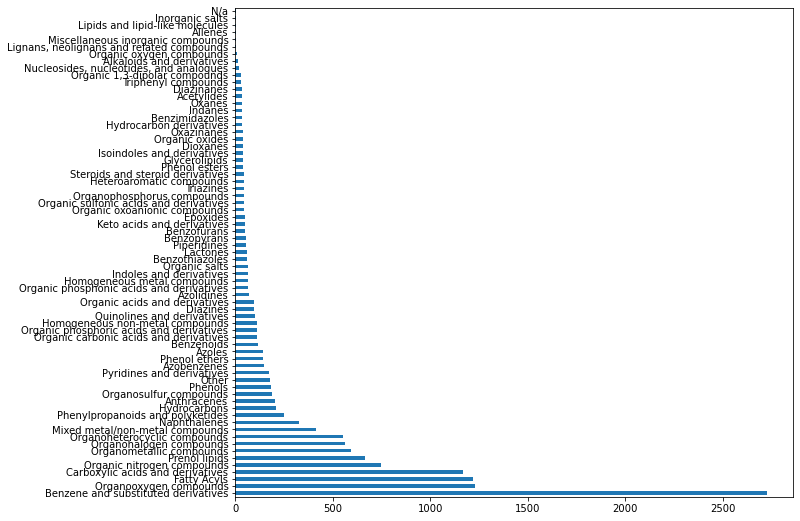

In [126]:
classyfire.ClassyFire.value_counts().plot.barh(figsize = (10,9))

In [129]:
classyfire[classyfire['ClassyFire'] == 'N/a']

,dtxsid,Kingdom,Superclass,Class,ClassyFire
7974,DTXSID9027651,Organic compounds,N/a,N/a,N/a


In [130]:
for index in classyfire.index:
    if classyfire.loc[index, 'ClassyFire'] == 'N/a':
        classyfire.loc[index, 'ClassyFire'] = 'Other'


In [131]:
classyfire[classyfire['ClassyFire'] == 'N/a']

,dtxsid,Kingdom,Superclass,Class,ClassyFire


In [139]:
req = dict(classyfire['dtxsid'].value_counts())


list({k for k,v in req.items() if v >1})

['DTXSID8023894', 'DTXSID001014393']

In [140]:
classyfire[classyfire['dtxsid'].isin(list({k for k,v in req.items() if v >1}))]

,dtxsid,Kingdom,Superclass,Class,ClassyFire
6935,DTXSID8023894,Other,Other,Other,Other
6936,DTXSID8023894,Other,Other,Other,Other
6937,DTXSID001014393,Other,Other,Other,Other
6938,DTXSID001014393,Other,Other,Other,Other


In [142]:
classyfire = classyfire.drop_duplicates()

In [143]:
tsca_df = pd.read_excel(interim_dir+'tsca_struct_input_080722_v1.xlsx', index_col = 0)

In [146]:
input_df = pd.merge(tsca_df, classyfire, on = 'dtxsid', how = 'left')

In [147]:
writer = pd.ExcelWriter(interim_dir+'TSCA_all_110822.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

input_df.to_excel(writer, sheet_name = 'TSCA_ALL')

writer.save()